In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

from PIL import Image
from IPython.display import display
import os


In [2]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
    

In [3]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
root = './Downloads/CATS_DOGS/CATS_DOGS'
train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform = test_transform)



train_loader = DataLoader(train_data, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 32, shuffle = False)

In [5]:
class_names = train_data.classes
class_names

['CAT', 'DOG']

In [6]:
print(len(train_loader))
print(len(test_loader))


586
196


In [7]:
class ConvulutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 2, 1)
        self.fc1 = nn.Linear(55*55*16, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 2)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 16*55*55)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim =1)
        

In [8]:
torch.manual_seed(42)
CNN =  ConvulutionalNetwork()


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN.parameters(), lr = 0.001)

In [10]:
CNN

ConvulutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=48400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=2, bias=True)
)

In [11]:
epochs = 3
train_accuracies = []
total_train_loss = []
 

for i in range(epochs):
    CNN.train()
    train_correction = 0
    total_train = 0
    running_loss = 0
    for b, (X_train , y_train) in enumerate(train_loader):
        y_pred = CNN(X_train)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        true_pred = torch.max(y_pred, 1)[1]
        train_correction += (true_pred == y_train).sum().item()
        total_train += y_train.size(0)
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = train_correction / total_train

    total_train_loss.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f' Epoch {i} has loss {epoch_loss:.2f} and accuracy of {epoch_accuracy * 100:.2f}%')
        

C:\Users\losha\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


 Epoch 0 has loss 0.61 and accuracy of 65.84%
 Epoch 1 has loss 0.54 and accuracy of 72.70%
 Epoch 2 has loss 0.50 and accuracy of 75.62%


In [18]:
 test_correction = 0
total_test = 0
 
with torch.no_grad():
    CNN.eval()
    for b, (X_test, y_test) in enumerate(test_loader):
        y_eval = CNN(X_test)
        y_true = torch.max(y_eval, 1)[1]
        test_correction += (y_true == y_test).sum().item()
        total_test += y_test.size(0)
        test_accuracy = test_correction / total_test
        test_accuracies.append(test_accuracy)

print(f' We got accuracy of {test_accuracy * 100:.2f}% ')
        
        
        
        

 We got accuracy of 76.26% 


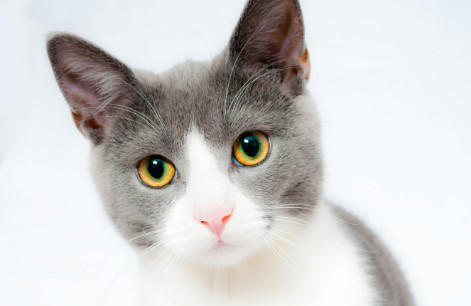

CAT


In [19]:
path_1 = './CAT.jpg'
image = Image.open(path_1)
display(image)
image_tensor_1 = test_transform(image).unsqueeze(0)

with torch.no_grad():
    new_pred = CNN(image_tensor_1).argmax()
print(class_names[new_pred.item()])
    





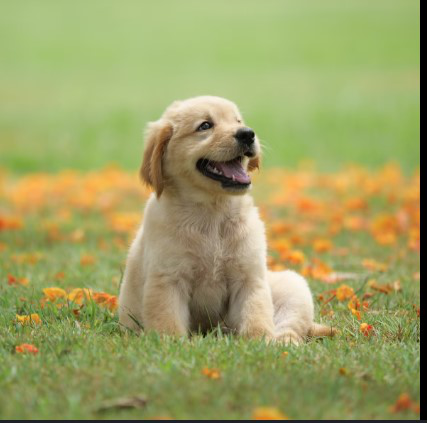

DOG


In [21]:
path_2 = './dog.jpg'
image_2 = Image.open(path_2)
display(image_2)

image_tensor_2 = test_transform(image_2).unsqueeze(0)

with torch.no_grad():
    new_pred_2 = CNN(image_tensor_2).argmax()
print(class_names[new_pred_2.item()])